In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Requirement 1
## Stochastic environments


## Bidding Environment

In [2]:
# auction blueprint
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


# second price auctions are truthful (bid == value) 
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        # ctrs = click-through rates (ad quality)
        self.ctrs = ctrs
        # assumed to be known by the auctioneer (can estimate them)
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # we compute the expected utility of each ad for the advertiser
        adv_values = self.ctrs*bids
        # sort the values in ascending order
        adv_ranking = np.argsort(adv_values)
        # the winner is chosen both based on its bid and the ad's ctr
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        # apply formula for payment of second price auctions
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

## Learning optimal bid

In [3]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 4
n_users = 1000
B = 150

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine (10*B), but they may not deplete it.

m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION

my_ctr = 0.85
my_valuation = 1

other_ctr = np.array([0.8, 0.95, 0.65, 0.75])
other_valuations = np.array([0.7, 1.1, 1.4, 0.85])

ctrs = np.append(my_ctr, other_ctr)

ctrs

# other_bids

array([0.85, 0.8 , 0.95, 0.65, 0.75])

In [4]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    # the clairvoyant knows the max bid at each round
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    # recall that operations with ndarray produce ndarray

    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 # total money spent
    i = 0 # index over the auctions
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1 # bid 1 in the remaining most profitable auction
        # recall that since this is a second-price auction what I pay doesn't depend on my bid (but determines if I win)
        # notice that since the competitors' bids are fixed < 1 the clairvoyant can just bid 1 to the auctions he wants to win and 0 to the rest
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

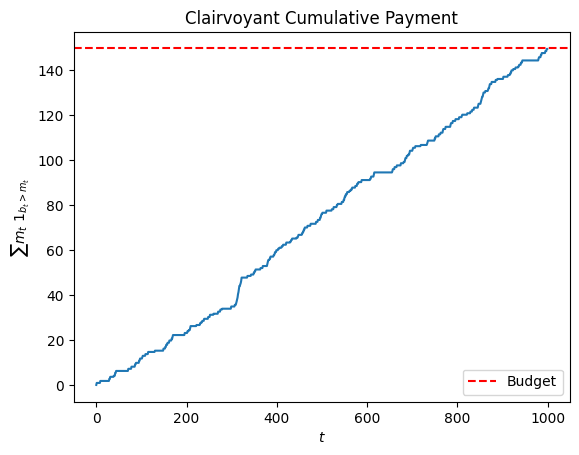

In [5]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show()

In [6]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [7]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18) # for experiment reproducbility purposes
for u in range(n_users): # for each auction
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t) # bandit feedback
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 152


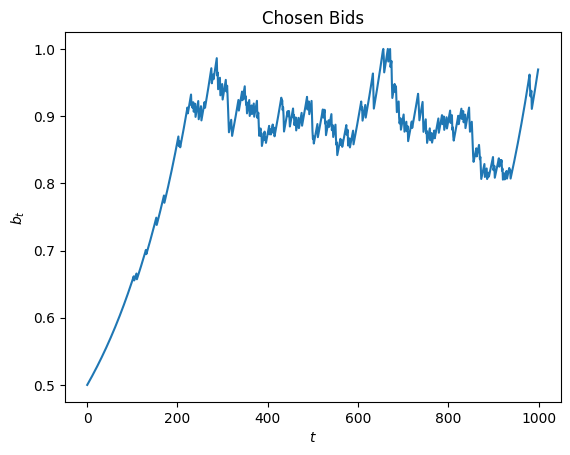

In [8]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

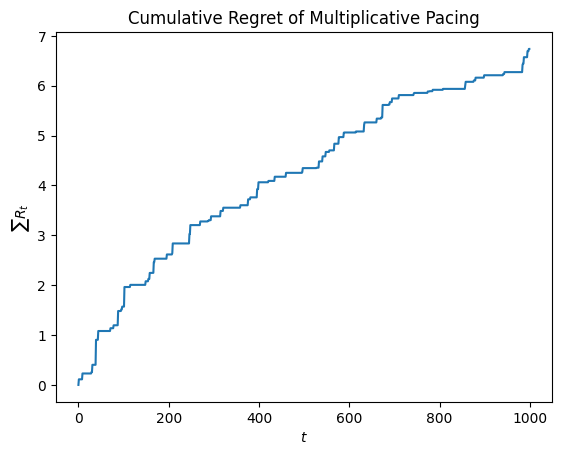

In [9]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities) 
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

### UCB-like Algorithm

In [35]:
from scipy.optimize import linprog
class UCBLikeAgent():
    def __init__(self, budget, T, bids):
        self.bids = bids
        self.K = len(self.bids)
        self.budget = budget
        self.T = T
        self.b_t = None
        self.f_avg = np.zeros(self.K)
        self.c_avg = np.zeros(self.K)
        self.N_pulls = np.zeros(self.K)
        self.rho = budget/T
        self.t = 0
    
    def bid(self):
        if self.budget < 1:
            return 0
        elif self.t < self.K:
            self.b_t = self.t # we first try every bid
            return self.b_t
        else:   
            f_ucbs = self.f_avg + np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_ucbs = self.c_avg + np.sqrt(2*np.log(self.T)/self.N_pulls)

            # Finding distribution gamma with linear programming
            c = -f_ucbs  

            A = c_ucbs.reshape(1,self.K) 
            b = np.array([self.rho])     # Upper bound for the inequality constraint

            A_eq = np.ones((1, len(f_ucbs)))  
            b_eq = np.array([1])  # The sum of the distribution should be 1

            bounds = [(0, 1) for _ in range(len(f_ucbs))]

            # Solving the linear program
            result = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            # Extract the optimized distribution over bids
            distribution = result.x
            sampled_bid = np.random.choice(range(self.K), p=distribution)
            self.b_t = sampled_bid
            
            return self.bids[self.b_t]
    
    def update(self, f_t, c_t):
        self.N_pulls[self.b_t] += 1
        self.f_avg[self.b_t] += (f_t - self.f_avg[self.b_t])/self.N_pulls[self.b_t]
        self.c_avg[self.b_t] += (c_t - self.c_avg[self.b_t])/self.N_pulls[self.b_t]
        
        self.budget -= c_t
        self.t += 1

In [36]:
n_bids = 100 # discretization of possible bids
bids = np.linspace(0, 10*B/n_users, n_bids) # set of possible bids
agent = UCBLikeAgent(budget=B, T=n_users, bids=bids)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18) # for experiment reproducbility purposes
for u in range(n_users): # for each auction
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t) # bandit feedback
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 125


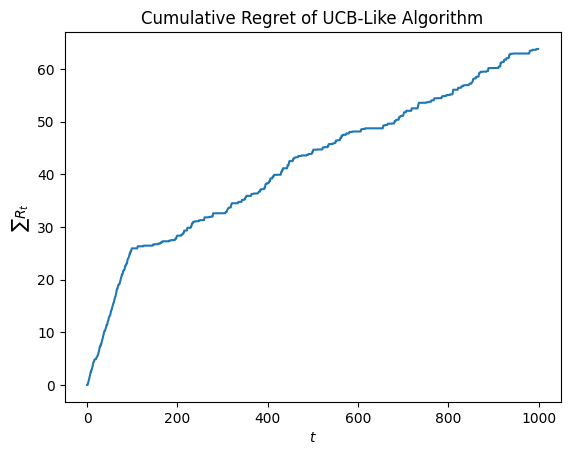

In [31]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities) 
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB-Like Algorithm')
plt.show()

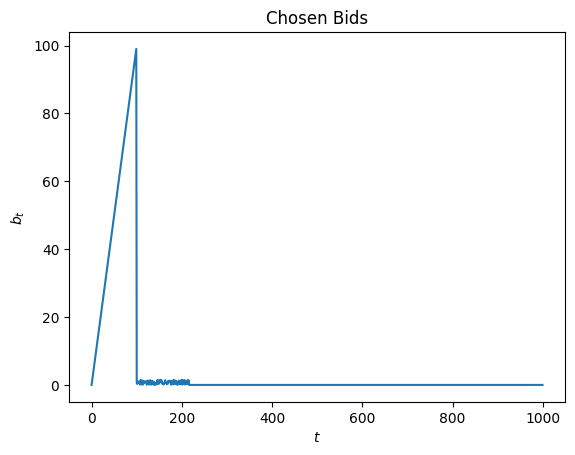

In [13]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

## Pricing Environment

In [14]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

## Gaussian Process

In [15]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

### GP-UCB Agent

In [16]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        # all formulas are in the linked paper
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t  # beta inflates the confidence (?) encourages exploration (it is increasing in time)
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

### Demand Curve

In [17]:
conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales

### Environment Initialization

In [18]:
# maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x
    
T = 500
min_price, max_price = 10, 20
n_customers = 1
cost = 10
agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# computation of the Clairvoyant

prices = np.linspace(min_price, max_price, 100)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)




## Learning demand curve

In [19]:
agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

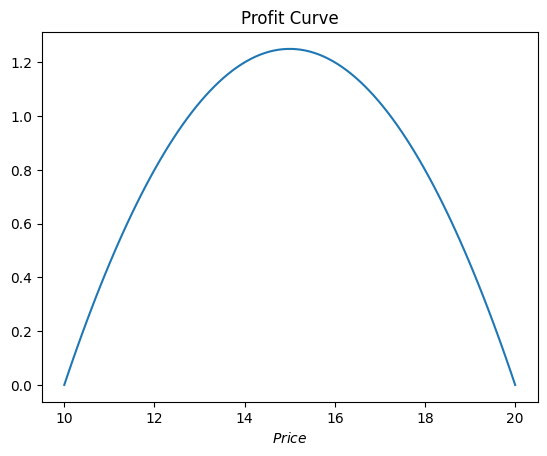

In [20]:
plt.figure()
plt.plot(prices, (prices - cost)*n_customers*conversion_probability(prices))
plt.title('Profit Curve')
plt.xlabel('$Price$')
plt.show()

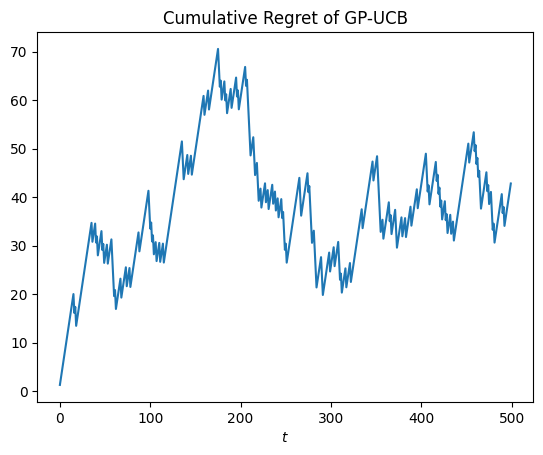

In [21]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show()

## Requirement 2 

In [22]:
# Non stationary env 
class NonStationaryEnvironment:
    def __init__(self, num_days, num_slots, price_levels):
        self.num_days = num_days
        self.num_slots = num_slots
        self.price_levels = price_levels
        self.bids = np.zeros((num_days, num_slots))
        self.buying_probabilities = np.zeros((num_days, len(price_levels)))
        self._generate_environment()

    def _generate_environment(self):
        for t in range(self.num_days):
            if t % 1000 == 0:  # Change the bids and buying probabilities periodically
                self.bids[t:] = np.random.rand(self.num_slots)
                self.buying_probabilities[t:] = np.random.rand(len(self.price_levels))

    def auction(self, bid, day):
        # Simulate a first-price auction
        competing_bids = self.bids[day, :]
        if bid > max(competing_bids):
            return True  # Slot won
        return False  # Slot lost

    def purchase(self, price, day):
        # Determine if the user buys the product given the price
        price_index = np.searchsorted(self.price_levels, price)
        purchase_probability = self.buying_probabilities[day, price_index]
        return np.random.rand() < purchase_probability


In [23]:
# Agent EXP3 with Primal-Dual adjustments
class EXP3AgentPrimalDual:
    def __init__(self, num_slots, num_prices, learning_rate):
        self.num_slots = num_slots
        self.num_prices = num_prices
        self.learning_rate = learning_rate
        
        # Initialize weights for both bids and prices
        self.bid_weights = np.ones(num_slots)
        self.price_weights = np.ones(num_prices)
        
        self.bid_probabilities = self.bid_weights / self.bid_weights.sum()
        self.price_probabilities = self.price_weights / self.price_weights.sum()

    def choose_bid(self):
        self.bid_probabilities = (1 - self.learning_rate) * (self.bid_weights / self.bid_weights.sum()) + \
                                 (self.learning_rate / self.num_slots)
        bid_slot = np.random.choice(self.num_slots, p=self.bid_probabilities)
        return bid_slot

    def choose_price(self):
        self.price_probabilities = (1 - self.learning_rate) * (self.price_weights / self.price_weights.sum()) + \
                                   (self.learning_rate / self.num_prices)
        price_level = np.random.choice(self.num_prices, p=self.price_probabilities)
        return price_level

    def update_bid(self, bid_slot, loss):
        estimated_loss = loss / self.bid_probabilities[bid_slot]
        self.bid_weights[bid_slot] *= np.exp(-self.learning_rate * estimated_loss / self.num_slots)

    def update_price(self, price_level, reward):
        estimated_reward = reward / self.price_probabilities[price_level]
        self.price_weights[price_level] *= np.exp(self.learning_rate * estimated_reward / self.num_prices)

In [24]:
#  Sim of the interation
def run_interaction(num_days, num_slots, price_levels, learning_rate, price_change_interval):
    environment = NonStationaryEnvironment(num_days, num_slots, price_levels)
    agent = EXP3AgentPrimalDual(num_slots, len(price_levels), learning_rate)

    cumulative_regret = np.zeros(num_days)
    cumulative_successes = np.zeros(num_days)

    for day in range(num_days):
        # Choose a bid and price
        bid_slot = agent.choose_bid()
        if day % price_change_interval == 0:
            price_level = agent.choose_price()
            price = price_levels[price_level]

        # Run the auction
        won_slot = environment.auction(agent.bid_weights[bid_slot], day)
        if won_slot:
            # If the auction is won, check if the product is purchased
            success = environment.purchase(price, day)
            reward = success  # Reward is binary: 1 if success, 0 otherwise
            loss = -1 * reward  # Regret is defined negatively in this context
        else:
            reward = 0
            loss = 1  # If slot is lost, consider it as a loss

        # Update the agent based on the result
        agent.update_bid(bid_slot, loss)
        agent.update_price(price_level, reward)

        # Cumulative metrics
        cumulative_regret[day] = loss
        cumulative_successes[day] = reward

    return cumulative_regret.cumsum(), cumulative_successes.cumsum(), agent


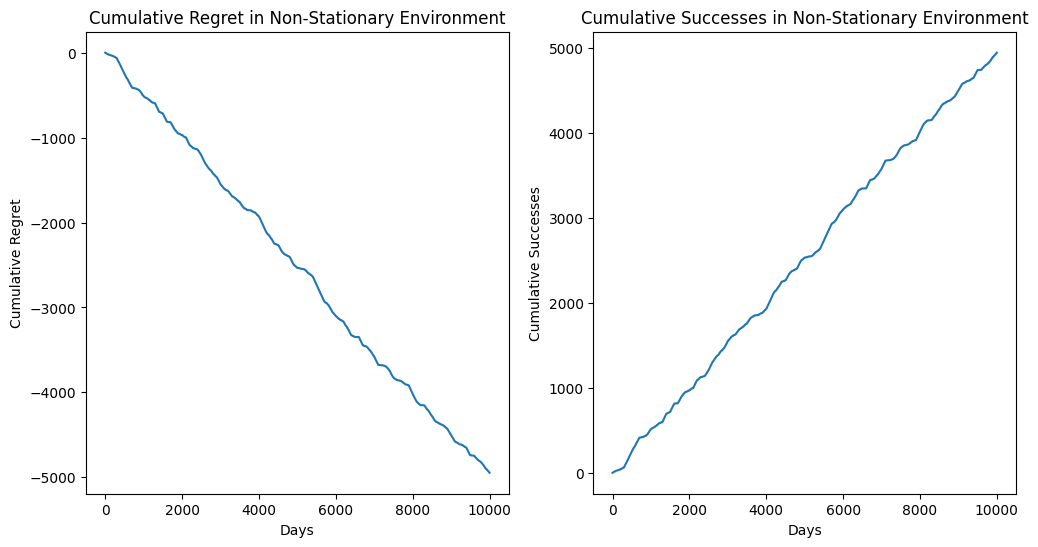

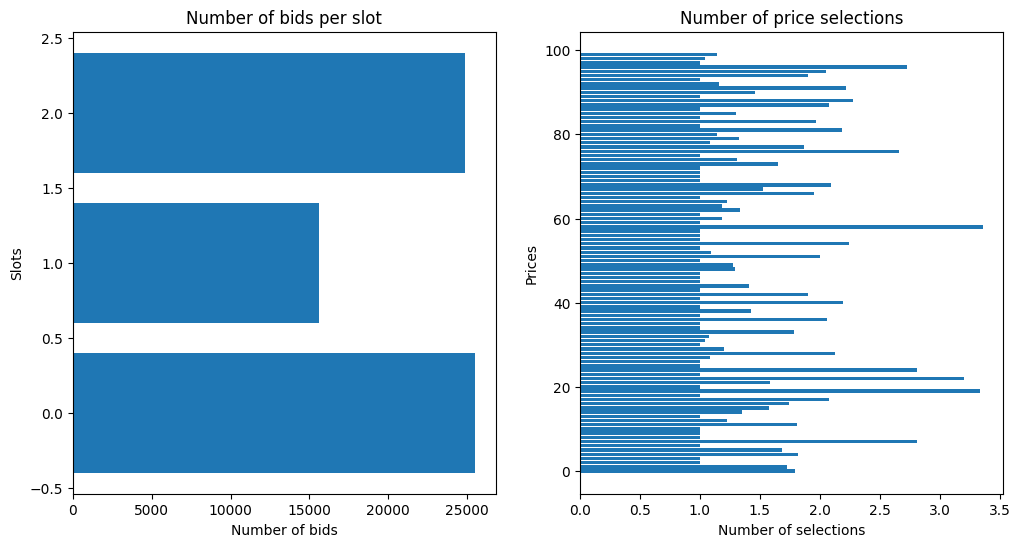

In [25]:

# Parameters
num_days = 10000
num_slots = 3
price_levels = np.linspace(0, 1, 100)  # Discrétisation de l'intervalle [0, 1] en 100 niveaux de prix
learning_rate = np.sqrt(np.log(num_slots) / (num_slots * num_days))
price_change_interval = 100  # Le prix peut changer tous les 100 jours

# execution of the interaction
cumulative_regret, cumulative_successes, agent = run_interaction(num_days, num_slots, price_levels, learning_rate, price_change_interval)

# Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cumulative_regret)
plt.title('Cumulative Regret in Non-Stationary Environment')
plt.xlabel('Days')
plt.ylabel('Cumulative Regret')

plt.subplot(1, 2, 2)
plt.plot(cumulative_successes)
plt.title('Cumulative Successes in Non-Stationary Environment')
plt.xlabel('Days')
plt.ylabel('Cumulative Successes')
plt.show()

# Nb of times each bid is chosen
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(y=np.arange(num_slots), width=agent.bid_weights)
plt.title('Number of bids per slot')
plt.ylabel('Slots')
plt.xlabel('Number of bids')

# Nb of times each prices is chosen
plt.subplot(1, 2, 2)
plt.barh(y=np.arange(len(price_levels)), width=agent.price_weights)
plt.title('Number of price selections')
plt.ylabel('Prices')
plt.xlabel('Number of selections')
plt.show()


## Requirement 3

In [26]:
# Non stationary env for tarification pb
class NonStationaryPricingEnvironment:
    def __init__(self, num_days, price_levels, intervals):
        self.num_days = num_days
        self.price_levels = price_levels
        self.intervals = intervals
        self.demand_curves = self._generate_demand_curves()
        self.noise_level = 5  #Noise level

    def _generate_demand_curves(self):
        demand_curves = {}
        for start, end in self.intervals:
            slope = -np.random.rand() * 100
            intercept = np.random.rand() * 300
            demand_curves[(start, end)] = lambda p: max(0, intercept + slope * p)
        return demand_curves

    def get_demand(self, day, price):
        for (start, end), demand_curve in self.demand_curves.items():
            if start <= day < end:
                demand = demand_curve(price)
                return max(0, demand + np.random.normal(0, self.noise_level))
        return 0


In [27]:

# Sliding-Window
class SlidingWindowPricing:
    def __init__(self, price_levels, window_size, exploration_period=200, random_reset_interval=100):
        self.price_levels = price_levels
        self.window_size = window_size
        self.history = []
        self.exploration_period = exploration_period  # Exploration period
        self.random_reset_interval = random_reset_interval  #We need to reexplore regularly

    def update_history(self, price, demand):
        self.history.append((price, demand))
        if len(self.history) > self.window_size:
            self.history.pop(0)

    def get_optimal_price(self, day):
        # Regular reexploration
        if day % self.random_reset_interval == 0:
            return np.random.choice(self.price_levels)
        
        if day < self.exploration_period:  #if exploration period is longer
            return np.random.choice(self.price_levels)
        
        avg_demand = {price: 0 for price in self.price_levels}
        count = {price: 0 for price in self.price_levels}

        for price, demand in self.history:
            avg_demand[price] += demand
            count[price] += 1

        avg_demand = {price: avg_demand[price] / count[price] if count[price] > 0 else 0 
                      for price in self.price_levels}

        # Optimal price for avg demand
        optimal_price = max(avg_demand, key=avg_demand.get)
        
        # We don't want to have a zero price too often
        if optimal_price == 0 and day > self.exploration_period:
            optimal_price = np.random.choice(self.price_levels[1:])  # random price
        
        return optimal_price


In [28]:

# CUSUM
class CUSUMPricing:
    def __init__(self, price_levels, threshold, drift):
        self.price_levels = price_levels
        self.threshold = threshold
        self.drift = drift
        self.history = {price: [] for price in price_levels}
        self.cusum_stat = {price: 0 for price in price_levels}

    def update_history(self, price, demand):
        self.history[price].append(demand)
        if len(self.history[price]) > 1:
            change = demand - np.mean(self.history[price][:-1])
            self.cusum_stat[price] = max(0, self.cusum_stat[price] + change - self.drift)
            if self.cusum_stat[price] > self.threshold:
                self.history[price] = []  # Reset history if change detected
                self.cusum_stat[price] = 0

    def get_optimal_price(self):
        if all(len(demand) == 0 for demand in self.history.values()):
            return np.random.choice(self.price_levels)
        
        avg_demand = {price: np.mean(self.history[price]) if len(self.history[price]) > 0 else 0
                      for price in self.price_levels}
        
        optimal_price = max(avg_demand, key=avg_demand.get)
        return optimal_price


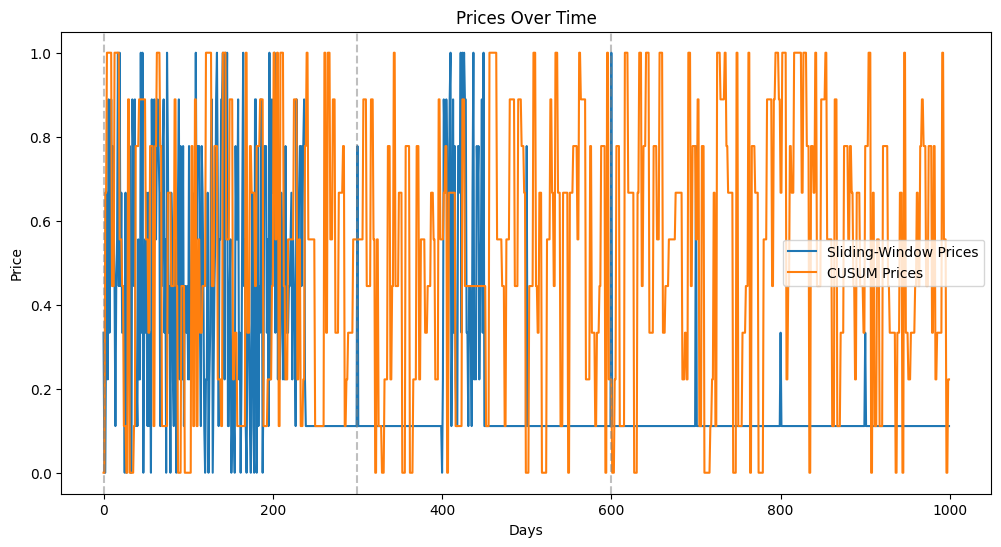

Total revenue for Sliding-Window strategy: 44562.992900014724
Total revenue for CUSUM strategy: 93795.87535917925


In [29]:

#Simlation of the interaction
def run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift):
    environment = NonStationaryPricingEnvironment(num_days, price_levels, intervals)
    sliding_window_strategy = SlidingWindowPricing(price_levels, window_size)
    cusum_strategy = CUSUMPricing(price_levels, cusum_threshold, cusum_drift)

    sliding_window_prices = []
    cusum_prices = []

    sliding_window_revenue = 0
    cusum_revenue = 0

    for day in range(num_days):
        # Update with Sliding-Window
        sliding_price = sliding_window_strategy.get_optimal_price(day)
        sliding_demand = environment.get_demand(day, sliding_price)
        sliding_window_strategy.update_history(sliding_price, sliding_demand)
        sliding_window_prices.append(sliding_price)
        sliding_window_revenue += sliding_price * sliding_demand

        # Update with CUSUM
        cusum_price = cusum_strategy.get_optimal_price()
        cusum_demand = environment.get_demand(day, cusum_price)
        cusum_strategy.update_history(cusum_price, cusum_demand)
        cusum_prices.append(cusum_price)
        cusum_revenue += cusum_price * cusum_demand

    return sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue

# Parameters
num_days = 1000
price_levels = np.linspace(0, 1, 10)
intervals = [(0, 300), (300, 600), (600, 1000)]
window_size = 50
cusum_threshold = 0.5
cusum_drift = 0.1

# Simulation
sliding_window_prices, cusum_prices, sliding_window_revenue, cusum_revenue = run_pricing_simulation(num_days, price_levels, intervals, window_size, cusum_threshold, cusum_drift)

# We print the results
plt.figure(figsize=(12, 6))
plt.plot(sliding_window_prices, label='Sliding-Window Prices')
plt.plot(cusum_prices, label='CUSUM Prices')
for interval in intervals:
    plt.axvline(x=interval[0], color='gray', linestyle='--', alpha=0.5)
plt.title('Prices Over Time')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display of total revenues
print(f"Total revenue for Sliding-Window strategy: {sliding_window_revenue}")
print(f"Total revenue for CUSUM strategy: {cusum_revenue}")


## Requirement 4